# Covertura de farmacias en México

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [98]:
import osmnx as ox
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('classic')
import igraph as ig
import numpy as np
from shapely.geometry import Polygon
import src 
import networkx as nx
%matplotlib inline

In [4]:
mpos = gpd.read_file('../data/external/LimitesPoliticos/MunicipiosMexico_INEGI19_GCS_v1.shp')

In [6]:
mpos['t']=0

In [8]:
mx = mpos.dissolve(by='t')
edos = mpos.dissolve(by='CVE_ENT')

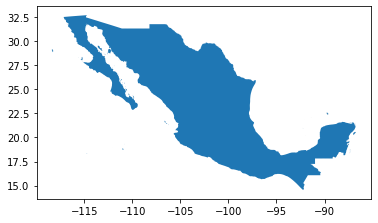

In [9]:
mx.plot()

In [79]:
resolution=4
hex_bins = src.create_hexgrid(mx,resolution)
hex_bins.to_crs(crs=mx.crs,inplace=True)
hex_bins.head(3)

,geometry,hex_id_4
0,"POLYGON ((-112.30378 29.27004, -112.53053 29.1...",844850dffffffff
1,"POLYGON ((-110.75954 27.80252, -110.71603 27.5...",84480b9ffffffff
2,"POLYGON ((-103.17245 25.65674, -103.19965 25.9...",8448127ffffffff


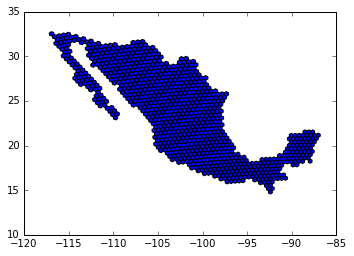

In [80]:
hex_bins.plot()

In [81]:
gdf = gpd.read_file('../data/external/DENUE/denue_00_46321-46531_shp/conjunto_de_datos/denue_inegi_46321-46531_.shp')
gdf = gdf[(gdf['codigo_act']=="464111")|(gdf['codigo_act']=="464112")]

In [82]:
pois_in_hex = gpd.sjoin(gdf, hex_bins)

In [83]:
pois_counts = pois_in_hex.groupby([f'hex_id_{resolution}']).agg(len)
pois_counts.drop('geometry',axis=1,inplace=True)

In [84]:
hex_new = pd.merge(hex_bins,pois_counts,right_index=True,left_on=f'hex_id_{resolution}',how = 'outer')
hex_new = hex_new.drop('index_right',axis=1)
hex_new.codigo_act.apply(lambda x: x+1 if x==0 else x )
hex_new.fillna(0, inplace=True)

In [85]:
title = 'Distribución de farmacias'

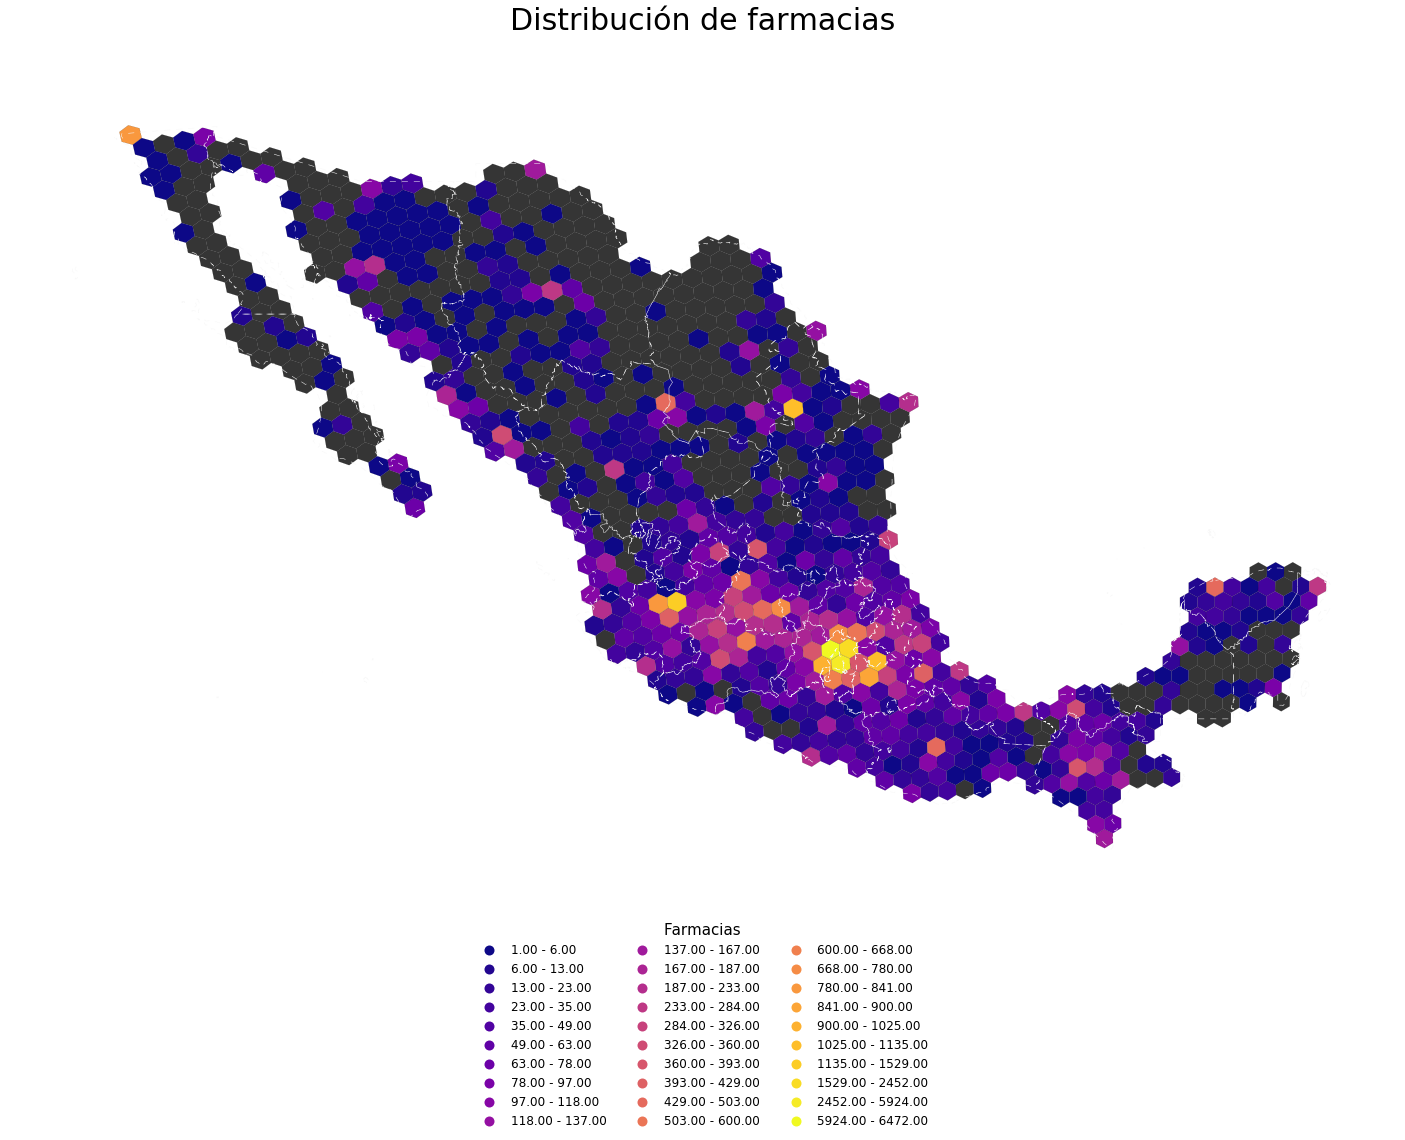

In [124]:
fig, ax = plt.subplots(1,1,figsize=(20,20))
hex_new[hex_new['codigo_act']<=0].plot(ax=ax,color='#2b2b2b', alpha=0.95, linewidth=0.1,edgecolor='k', zorder=1)
hex_new[hex_new['codigo_act']>0].plot(ax=ax,column='codigo_act', scheme='fisher_jenks',linewidth=0.1, cmap='plasma', zorder=3, 
                                      legend=True,k=30,legend_kwds={'title':'Farmacias','title_fontsize':15,'ncol':3,'loc':8,'bbox_to_anchor':(0.5, -0.11),'frameon':False})
edos.boundary.plot(ax=ax,color='#f8f8f8',zorder=3,linestyle='--',linewidth=0.5)
ax.set_title(f'{title}',fontdict={'fontsize':30})
fig.tight_layout()
ax.axis('off')
plt.savefig('../output/figures/Mexico_Farmacias.png',dpi=300,transparent=False,);